In [1]:
# importing packages and modules
import pandas as pd 
import numpy as np
from pathlib import Path
import math
import pickle
import matplotlib.pyplot as plt
import scipy.stats as stats


In [15]:
ourP = np.zeros((2,2))
ourP[0,0]=0.97
ourP[0,1]=0.03
ourP[1,0]=.05
ourP[1,1]=.95
print("True Transition Matrix P")
print(ourP)



True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


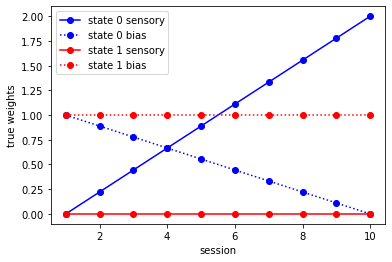

In [3]:
s = 10 # sessions
t = 500 # trials per session
k = 2 # states
d = 2 # features (sensory & bias)
ourW = np.zeros((s,k,d))
ourW[:,0,0] = np.linspace(0,2,s) # state 1 sensory (increasing)
ourW[:,0,1] = np.linspace(1,0,s) # state 1 bias (decreasing)
ourW[:,1,0] = 0 # state 2 sensory (flat 0)
ourW[:,1,1] = 1 # state 2 bias (flat 1)
plt.plot(range(1,s+1),ourW[:,0,0],color='blue',marker='o',label='state 0 sensory')
plt.plot(range(1,s+1),ourW[:,0,1],color='blue',marker='o',linestyle=':',label='state 0 bias')
plt.plot(range(1,s+1),ourW[:,1,0],color='red',marker='o',label='state 1 sensory')
plt.plot(range(1,s+1),ourW[:,1,1],color='red',marker='o',linestyle=':',label='state 1 bias')
plt.ylabel("true weights")
plt.xlabel('session')
plt.legend()
plt.show()

In [6]:
def emission_probability(x, z, w, plot=False):
    '''
    X: N x D numpy array
    Z: N x 1 numpy array
    W: N x K x D 
    '''
    n = x.shape[0]
    d = x.shape[1]
    k = w.shape[1]
    phi = np.empty((n,)) # probability that it is state 1
    for t in range(0,n):
        phi[t] = 1/(1+math.exp(-w[t,z[t],:]@x[t,:]))
    if(plot==True):
        plt.title("histogram for emission probabilities of y_t=1")
        plt.hist(phi,[0,0.2,0.4,0.6,0.8,1])
        plt.show()
    return phi

In [16]:
def simulate_data(true_w, true_P,priorZstart,trials):
    '''
    function that simulates X and Y data from true weights and true transition matrix
    S sessions, K states, D features (in the order: sensory, bias)
    K = 2 BINOMIAL

    Parameters
    ----------
    true_w: S x K x D numpy array
        true weight matrix
    true_P: K X K numpy array
        true probability transition matrix
    priorZstart: int
        prior for initial latent state to be 0
    t : int 
        number of trials per session
        
    Returns
    -------
    '''

    # check that weights and transition matrix are valid options

    s = true_w.shape[0] # sessions
    k = true_w.shape[1] # states
    d = true_w.shape[2] # features
    n = s * trials # total number datapoints
    x = np.empty((n,d))
    y = np.empty((n,))
    z = np.empty((n,),dtype=int)
    w = np.empty((n,k,d)) # weights

    # input data x
    x[:,1] = 1 # bias term
    x[:,0] = stats.uniform.rvs(loc=-16,scale=33,size=n).astype(int)
    x[:,0] = x[:,0] - x[:,0].mean()
    x[:,0] = x[:,0] / x[:,0].std()

    # change weight format to have session*trials points
    for sess in range(0,s):
        for t in range(0,trials):
            w[sess*trials+t,:,:] = true_w[sess,:,:]

    # latent variables z 
    for t in range(0,n):
        if (t % trials==0): # beginning of session has a new draw for latent
            z[t] = np.random.binomial(n=1,p=1-priorZstart)
        else:
            z[t] = np.random.binomial(n=1, p=true_P[z[t-1],1])

    # for sess in range(0,s): # true weight are the same within one session
        
    #     # # choice/output data y
    #     # y[t] = np.random.binomial(n=1,p=1/(1+math.exp(-true_w[sess,])))
    phi = emission_probability(x,z,w,plot=False)

    for t in range(0,n):
        y[t] = np.random.binomial(n=1,p=phi[t])
    
    print(z.sum())

    return x, y, z, w

x_sim, y_sim, z_sim, w_sim = simulate_data(true_w=ourW, true_P=ourP, priorZstart=0.5, trials=500)

1916


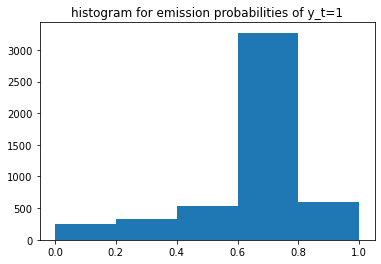

array([0.73105858, 0.73105858, 0.73105858, ..., 0.27127604, 0.09031826,
       0.91017998])

In [17]:
emission_probability(x_sim, z_sim, w_sim, plot=True)



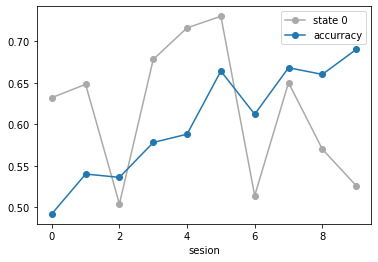

In [18]:
def accuracy(x,y,z,s):
    '''
    X: N x D numpy array
    Y: N x 1 numpy array
    '''
    n = x.shape[0]
    perf = np.zeros((s,))
    trials = int(n/s)
    state0 = np.empty((s,))
    ind = []
    for sess in range(0,s):
        state0[sess] = trials - z_sim[sess*trials:(sess+1)*trials].sum()
        for t in range(0,trials):
            if (x[sess*trials+t,0]>0 and y[sess*trials+t]==1):
                perf[sess]+=1
            elif (x[sess*trials+t,0]<0 and y[sess*trials+t]==0):
                perf[sess]+=1
            else:
                ind.append(sess*trials+t)

    perf = perf / trials # normalize to number of trials per session
    state0 = state0 / trials
    plt.plot(range(0,s),state0,marker='o',color='darkgray',label='state 0')
    plt.plot(range(0,s),perf,marker='o',label="accurracy")
    plt.xlabel("sesion")
    plt.legend()
    plt.show()

    return perf, ind
perf,ind = accuracy(x_sim,y_sim,z_sim,s=10)

In [154]:
print(z_sim.sum())
print(z_sim[4500:].sum())

1868
247
